In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import date


%matplotlib inline
pd.set_option('display.max_columns', 500)

## Read Data and Inspect

In [351]:
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [352]:
logins.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [353]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [354]:
file = open('ultimate_data_challenge.json', 'r')

trips = pd.DataFrame(json.load(file))
file.close()

trips.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [355]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


**Data Quality Observations:**

 1. The logins and trips datasets are relatively complete. The logins data does not contain any NULL values. The trips data has NULL values for the average rating columns and the phone column. The highest incidence of NULLs is in the trips data for the avg_rating_of_driver column. This column has 16% null values.
 
 2. The logins data spans from January 1970 to April 1970. The problem statement does not indicate when this data was collected, but we have reason to believe these dates are inaccurate. Cellphones were not used in the 1970s. Further, the trips data is related to customers joining Ultimate in January 2014. For our analysis, we will assume that the logins data should be reset to a January 2014 base period, consistent with the trips data (**Assumption 1**).
 

In [356]:
#rebase logins data - January 2014
delta = pd.to_timedelta(pd.to_datetime('1/1/2014 00:00') - pd.to_datetime('1/1/1970 00:00'), unit = 'D')
logins = logins.apply(lambda x: x + delta)

logins.head()

,login_time
0,2014-01-01 20:13:18
1,2014-01-01 20:16:10
2,2014-01-01 20:16:37
3,2014-01-01 20:16:36
4,2014-01-01 20:26:21


# Part 1 Exploratory Data Analysis - Logins

In [357]:
#aggregate login counts based on 15-minute time intervals
#set index
logins.set_index('login_time', inplace = True)
logins['count'] = 1
logins = logins.resample('15T').sum()

logins.head()

,count
login_time,
2014-01-01 20:00:00,2
2014-01-01 20:15:00,6
2014-01-01 20:30:00,9
2014-01-01 20:45:00,7
2014-01-01 21:00:00,1


 ## A. Plot logins by Month

The below code creates a plot for each month in our dataset that shows a trendline for ridership logins over 15 minute intervals. Friday and Saturday activity is highlighted in green. Holiday activity is highlighted in Red. The blue trendline represents the average login count for the month, and the yellow trendline represents the 98% login count for the month.

**Define Function to Highlight Logins on Fridays, Saturdays, and Holidays:**

In [358]:
def find_friSat_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() in [4,5]:
            indices.append(i)
    return indices

def highlight_friSat(indices, plt, df):
    i = 0
    while i < len(indices)-1:
        plt.axvspan(df.index[indices[i]], df.index[indices[i] + 1], facecolor='green', edgecolor='none', alpha=.5)
        i += 1

def find_holiday_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].strftime('%Y-%m-%d') in ['2014-01-01', '2014-01-20', '2014-02-17', '2014-03-17', '2014-04-20']:
            indices.append(i)
    return indices

def highlight_holidays(indices, plt, df):
    i = 0
    while i < len(indices)-1:
        plt.axvspan(df.index[indices[i]], df.index[indices[i] + 1], facecolor='red', edgecolor='none', alpha=.5)
        i += 1
        


**January**

(array([735234., 735241., 735248., 735255., 735262.]),
 <a list of 5 Text xticklabel objects>)

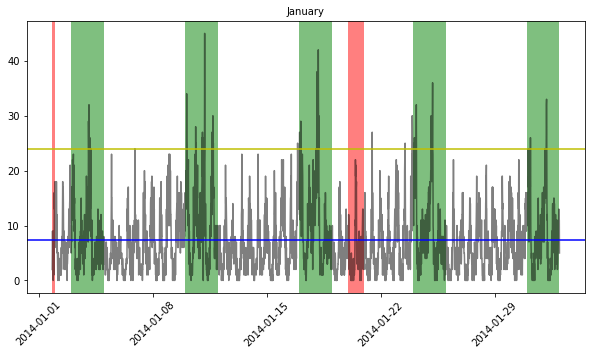

In [359]:
plt.figure(figsize = (10,5))
df = logins['2014-01-01': '2014-02-01']
friSat_indices = find_friSat_indices(df.index)
holiday_indices = find_holiday_indices(df.index)

plt.plot(df, color='black', alpha=.5)
plt.axhline(y=df['count'].mean(), color='b', linestyle='-')
plt.axhline(y=df['count'].quantile(.98), color='y', linestyle='-')

highlight_friSat(friSat_indices, plt, df)
highlight_holidays(holiday_indices, plt, df)

plt.title('January', fontsize=10)
plt.xticks(rotation = 45)


**February**

(array([735264., 735271., 735278., 735285., 735292.]),
 <a list of 5 Text xticklabel objects>)

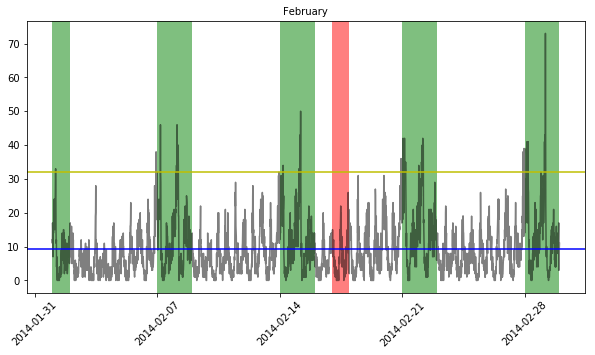

In [360]:
plt.figure(figsize = (10,5))
df = logins['2014-02-01': '2014-03-01']
friSat_indices = find_friSat_indices(df.index)
holiday_indices = find_holiday_indices(df.index)

plt.plot(df, color='black', alpha=.5)
plt.axhline(y=df['count'].mean(), color='b', linestyle='-')
plt.axhline(y=df['count'].quantile(.98), color='y', linestyle='-')

highlight_friSat(friSat_indices, plt, df)
highlight_holidays(holiday_indices, plt, df)

plt.title('February', fontsize=10)
plt.xticks(rotation = 45)

**March**

(array([735295., 735302., 735309., 735316., 735323.]),
 <a list of 5 Text xticklabel objects>)

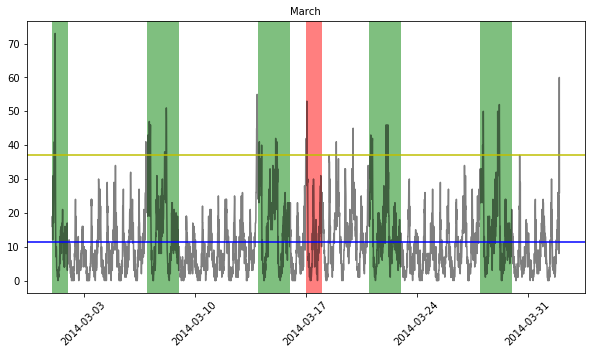

In [361]:
plt.figure(figsize = (10,5))
df = logins['2014-03-01': '2014-04-01']
friSat_indices = find_friSat_indices(df.index)
holiday_indices = find_holiday_indices(df.index)

plt.plot(df, color='black', alpha=.5)
plt.axhline(y=df['count'].mean(), color='b', linestyle='-')
plt.axhline(y=df['count'].quantile(.98), color='y', linestyle='-')

highlight_friSat(friSat_indices, plt, df)
highlight_holidays(holiday_indices, plt, df)

plt.title('March', fontsize=10)
plt.xticks(rotation = 45)

**April**

(array([735325., 735327., 735329., 735331., 735333., 735335., 735337.]),
 <a list of 7 Text xticklabel objects>)

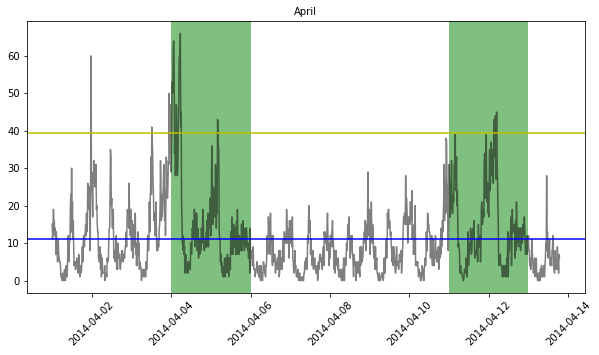

In [362]:
plt.figure(figsize = (10,5))
df = logins['2014-04-01': '2014-05-01']
friSat_indices = find_friSat_indices(df.index)
holiday_indices = find_holiday_indices(df.index)

plt.plot(df, color='black', alpha=.5)
plt.axhline(y=df['count'].mean(), color='b', linestyle='-')
plt.axhline(y=df['count'].quantile(.98), color='y', linestyle='-')

highlight_friSat(friSat_indices, plt, df)
highlight_holidays(holiday_indices, plt, df)

plt.title('April', fontsize=10)
plt.xticks(rotation = 45)

**General Observations:**

We defined a 'peak' in activity as a 15 minute interval where login counts were in the top 2% for a given month.

 1. Accross all months, ridership activity peaks most often on Friday and Saturdays.
 2. Ridership peaks for some but not all holidays.
 3. There were ridership peaks on January  21, March 20, 21, 31 and April 2. These were neither Holidays nor Fridays/Saturdays. There may be some other explanation for these peak periods (sporting or cultural events, company promotions).
 

**Data Quality Observations:**

 The April data is not complete. Data is only available through April 14, 2014.

# Part 2 - Experiment and Metrics Design

I would propose an A/B test using Bayes Theorem and MCMC simulation. We can measure the proportion of rides spanning accross both cities before and after the change. Then, we can create credible distributions of the proportion of rides spanning both cities for the pre and post change data sets. If our post-change dataset shows an increase in the percentage of rides spanning both cities, based on some pre-defined criteria (e.g. the new average proportion is outside the 90%, or 95% credible interval of the prior distribution), then we can accept that the change in policy has encouraged an increase in cross-boundary rides.

# Part 3 - Predictive Modeling

In [363]:
#replace nulls
#ratings - impute average
avg = trips['avg_rating_by_driver'].mean()
trips['avg_rating_by_driver'].fillna(avg, inplace=True)

avg = trips['avg_rating_of_driver'].mean()
trips['avg_rating_of_driver'].fillna(avg, inplace=True)

#phone types - other
trips['phone'].fillna('Other', inplace = True)

In [364]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [365]:
print('Datespan:\n', trips['signup_date'].min(), 'to', trips['signup_date'].max())
print('Most recent last trip dates:\n', sorted(trips['last_trip_date'].unique())[-10:])

Datespan:
 2014-01-01 to 2014-01-31
Most recent last trip dates:
 ['2014-06-22', '2014-06-23', '2014-06-24', '2014-06-25', '2014-06-26', '2014-06-27', '2014-06-28', '2014-06-29', '2014-06-30', '2014-07-01']


The most recent last trip date in our data set was July 1, 2014. As such, we will define our retained drivers as those that signed up in January 2014 and have been active within the most recent 30 day period, ending on July 1, 2014.

In [366]:
trips['retained'] = np.where(trips['last_trip_date'] >= '2014-06-01', 1, 0)
print(trips['retained'].mean() * 100, 'percent of drivers who signed up in January 2014 were retained.')

37.608000000000004 percent of drivers who signed up in January 2014 were retained.


In [367]:
trips.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

In [368]:
trips = pd.get_dummies(trips, columns = ['city', 'phone', 'ultimate_black_user'])

trips.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1,0,1,0,0,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0,1,0,0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0,1,0,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1,0,1,0,0,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,0,0,1,1,0,0,1,0


In [369]:
from sklearn.model_selection import train_test_split

target = trips['retained']
variables = trips
variables.drop('retained', axis = 1, inplace = True)

x_train, x_test, y_train, y_test = train_test_split(variables, target, test_size=0.25, random_state=0)

In [370]:
from sklearn.linear_model import LogisticRegression

#create object
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)


predictions = logisticRegr.predict(x_test)

In [371]:
score = logisticRegr.score(x_test, y_test)
print(score)

0.71912


In [372]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

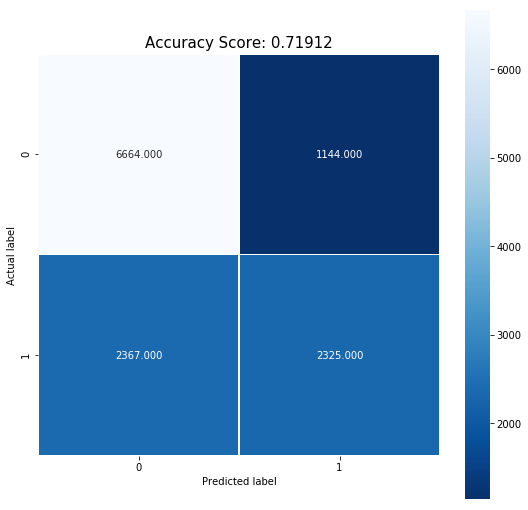

In [373]:
cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

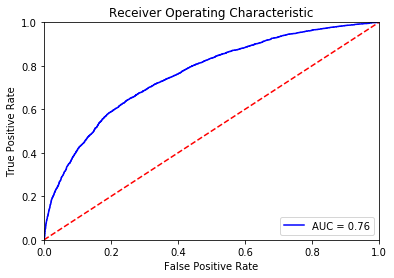

In [374]:
# calculate the fpr and tpr for all thresholds of the classification
probs = logisticRegr.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [375]:
fieldList = np.array(list(variables)).reshape(-1,1)

coeffs = np.reshape(np.round(logisticRegr.coef_,5),(-1,1))
coeffs=np.concatenate((fieldList,coeffs),axis=1)
coeffs = pd.DataFrame(coeffs,columns=['Field','Coeff'])
coeffs.sort_values(['Coeff'], ascending = False)

,Field,Coeff
8,city_King's Landing,1.04979
12,phone_iPhone,0.67502
14,ultimate_black_user_True,0.56837
5,trips_in_first_30_days,0.1182
11,phone_Other,0.03558
4,surge_pct,0.00389
7,city_Astapor,-0.65147
10,phone_Android,-0.43935
13,ultimate_black_user_False,-0.29711
3,avg_surge,-0.20276


**Final Observations:**

 1. Our model performs relatively well, with a 71% accuracy and .75 AUC. A potential next step would be to utilize non-linear model types like decision trees / random forests.
 2. A rider having an Android is associated with a -.43 decrease in the logodds of retention. This suggests that the Android app may not function as well as the Iphone app. Iphone usage is associated with a .67 increase in the log odds of retention.
 3. Users from King's Landing are more likely to be retained. Further investigation is needed to determine the reason. If Ultimate conducts business differently in King's Landing (e.g. offers more promotions, etc.), it may be able to retain more customers by expanding these services to other neighborhoods.